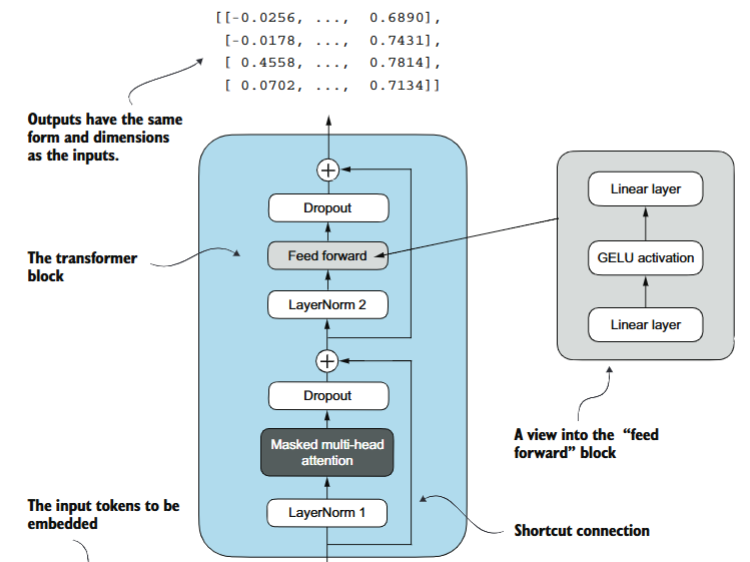

#### Layer Normalization

Layer normalization is something very important to understand before we dive into the GPT-2 architecture.

Think of it this way: in a large model with millions of parameters, gradients can sometimes grow uncontrollably (exploding gradient) or shrink down to almost nothing (vanishing gradient). Both of these situations make training unstable.

Layer normalization is one of the tools that helps keep this problem under control. It also addresses what is known as internal covariate shift, which happens when the distribution of activations changes during training, making learning harder.

What does layer normalization do exactly? It looks at all the values in a layer for a single training example, then adjusts them so that the mean becomes close to 0 and the variance close to 1.

Mathematically, it can be written as:

x(new) = (x - mean) / sqrt(variance)

This means every input is normalized based on the average and spread of the values in that layer, which keeps everything more balanced and makes learning smoother.

Let us see the impact of Layer Normalization with a simple code example.

In [ ]:
import torch
import torch.nn as nn

torch.manual_seed(123)

# A batch with 2 examples, each having 5 features
batch_example = torch.randn(2, 5)

# A simple layer without normalization
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)

print("Output without LayerNorm:\n", out)
print("Mean per sample:", out.mean(dim=1))
print("Variance per sample:", out.var(dim=1, unbiased=False))


Output without LayerNorm:
 tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean per sample: tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)
Variance per sample: tensor([0.0192, 0.0332], grad_fn=<VarBackward0>)


Now, let us apply Layer Normalization after the linear layer:

In [ ]:
layer_norm = nn.Sequential(
    nn.Linear(5, 6),
    nn.ReLU(),
    nn.LayerNorm(6)   # normalize across features
)
out_norm = layer_norm(batch_example)

print("\nOutput with LayerNorm:\n", out_norm)
print("Mean per sample:", out_norm.mean(dim=1))
print("Variance per sample:", out_norm.var(dim=1, unbiased=False))



Output with LayerNorm:
 tensor([[-0.8308,  0.8704, -0.8308, -0.1520, -0.8308,  1.7741],
        [-1.3366,  1.4465,  0.3605,  0.9735, -0.7403, -0.7036]],
       grad_fn=<NativeLayerNormBackward0>)
Mean per sample: tensor([4.2220e-08, 1.9868e-08], grad_fn=<MeanBackward1>)
Variance per sample: tensor([0.9998, 0.9999], grad_fn=<VarBackward0>)


After applying LayerNorm, you will observe that each sample’s mean is very close to 0 and variance close to 1.

This shows how Layer Normalization balances the output, making training more stable and helping the model learn efficiently even when parameters grow very large.

In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", out_norm.mean(dim=1))
print("Variance:\n", out_norm.var(dim=1, unbiased=False))

Mean:
 tensor([    0.0000,     0.0000], grad_fn=<MeanBackward1>)
Variance:
 tensor([0.9998, 0.9999], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-success">

Let's now encapsulate this process in a PyTorch module that we can use in the GPT
model later:
</div>

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-warning">

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim).

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization.

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task.

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

</div>

_A small note on biased variance_

<div class="alert alert-block alert-success">

Let's now try the LayerNorm module in practice and apply it to the batch input:
</div>

In [ ]:
print(batch_example)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-info">

As we can see based on the results, the layer normalization code works as expected and
normalizes the values of each of the two inputs such that they have a mean of 0 and a
variance of 1:
</div>

#### GELU activation function

GELU, or Gaussian Error Linear Unit, is an activation function that became popular with the Transformer family, including GPT models.
Unlike ReLU, which either completely blocks negative values (sets them to zero) or lets positive values pass, GELU is smoother and more probabilistic.

Think of it like this: instead of saying “everything negative goes to zero, everything positive passes through”, GELU softly decides how much of each input should flow forward. Negative inputs are not entirely discarded; instead, they are smoothly pushed closer to zero.

The mathematical approximation of GELU looks like this:

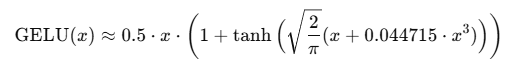

This formula may look a bit heavy, but the key takeaway is: GELU makes the transition between negative and positive smoother than ReLU, and this smoothness helps large language models like GPT train better.

Now, let us compare GELU with ReLU using a simple visualization.

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

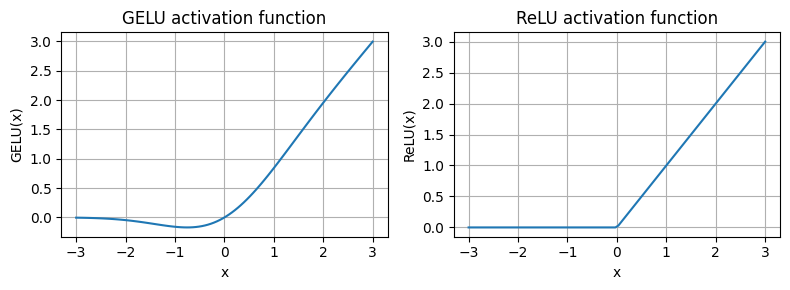

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">

As we can see in the resulting plot, ReLU is a piecewise linear function that
outputs the input directly if it is positive; otherwise, it outputs zero.

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.
</div>

<div class="alert alert-block alert-warning">

The smoothness of GELU, as shown in the above figure, can lead to better optimization properties
during training, as it allows for more nuanced adjustments to the model's parameters.

In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder,
especially in networks that are very deep or have complex architectures.

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output
for negative values.

This characteristic means that during the training process, neurons that
receive negative input can still contribute to the learning process, albeit to a lesser extent
than positive inputs.

</div>

#### Residual Connection/ Shortcut Connection

Sometimes, when we stack many layers in a deep neural network, the gradients during backpropagation can become very small as they travel backward through the layers. This is the vanishing gradient problem, and it makes training deep models extremely difficult.

A brilliant trick to fight this problem is adding **shortcut (or skip) connections**. These connections allow the signal to “jump over” certain layers, which keeps the gradient flow alive and prevents it from disappearing.

The idea is simple: instead of just passing the output of one layer to the next, we add it to the original input (if their shapes match). This way, the network can decide whether to rely more on the transformed output or the shortcut path.

The following code shows a deep neural network class that lets us toggle shortcut connections on or off. It has five layers, each consisting of a Linear layer followed by a GELU activation function:

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


Let’s first build a model without shortcut connections. We’ll give it an input of three values, and the last layer will return a single value:

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)


Next, we’ll define a helper function to compute the gradients during the backward pass. This will help us see how gradients change across layers:

In [ ]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


Now let’s use this function with our model without skip connections:

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


If you check the output, you’ll notice that the gradients are larger in the last layer but become smaller and smaller as we go back toward the first layer. This shrinking of gradients is exactly what we call the **vanishing gradient problem.**

Now, let’s build another model, this time with skip connections enabled:

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


With skip connections, the gradients no longer vanish completely. They still decrease somewhat, but they remain strong enough to keep the early layers learning effectively.

In conclusion, shortcut connections are a simple yet powerful idea. They prevent gradients from vanishing, make training deep models easier, and form the backbone of modern architectures like ResNets and Transformers. Without them, training very large models such as GPT would be nearly impossible.

#### Feed Forward Neural Network

In the Transformer architecture, and especially in GPT, every attention block is followed by a feedforward neural network. Think of it like this: the self-attention mechanism is really good at letting tokens "talk" to each other and exchange information, but once that information is gathered, we need a way to process and transform it further. That’s where the **feedforward network** comes in.

You can think of the feedforward network as a kind of “processing station” that sits after attention. First, the token embedding goes into a bigger hidden space (we expand its dimensionality), then we apply a non-linear transformation, and finally we shrink it back to its original size. This expansion and contraction acts like allowing the token to think in a larger hidden workspace, perform richer computations, and then bring the result back to its original format.

Here’s the code for a simple feedforward network that we’ll use later in GPT-like models:

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # Expansion
            GELU(),  # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),  # Contraction
        )

    def forward(self, x):
        return self.layers(x)

Notice the steps here:

- **Expansion:** We multiply the embedding dimension by 4. This is a common design choice in Transformers because it gives the model extra capacity to compute richer representations.

- **Non-linearity (GELU):** This helps the model capture complex patterns. It’s smoother than ReLU and works very well for large language models.

- **Contraction:** Finally, we map everything back down to the original embedding size, so the input and output dimensions match.

So, each token passes through attention to gather context, and then through this feedforward network to refine its meaning. By stacking these blocks many times, we get the powerful processing ability of models like GPT.

Created by **Md. Shadikur Rahman Sheam**.
- [Linkedin](https://www.linkedin.com/in/md-shadikur-rahman-sheam-3826482b3/)
- [Github](https://github.com/sadikurSenpai)
- [Facebook](https://www.facebook.com/profile.php?id=100091833665881)

Special thanks to Sebastian Raschka for his amazing book.